# Introduction 

The project uses the data from the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) to see if the ages can be predicted from using the other features. As it stands, the method for calculating the age of an abalone is to 'cut the shell through the cone, stain it, and count thenumber of rings through a microscope'. This is quite a barbaric thing to do! Ending the life of an animal just to work out its age. If only it could tell you its age! 

Thankfully, there is another method of working out its age - by using machine learning techniques on its other features (such as its length and weight). This project explores that, although there are some features such as 'shell weight', and it is not clear whether or not the shell has to be taken off the abalone. 

## Import libraries

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

## Read the data

In [175]:
abalone = pd.read_csv('abalone.csv')
abalone.shape

(4177, 9)

So, there are 4,177 rows (different abalones studied), and 9 columns (different features studied).

In [176]:
abalone.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Data visualisation



One thing to note is that there is no 'age' column in the data. According to UC Davis, in order to tell the age of an abalone, you count its rings and add 1.5 to it. Let's add a column indicating this, and remove the rings column. 

In [177]:
abalone['age'] = abalone.rings+1.5
abalone = abalone.drop('rings', axis=1)
features = abalone.drop('age', axis=1)
ages = abalone.age

In [178]:
abalone.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


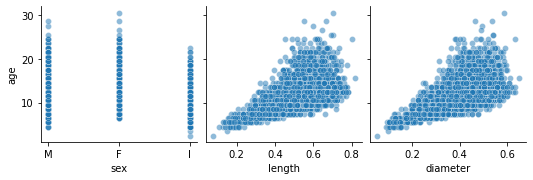

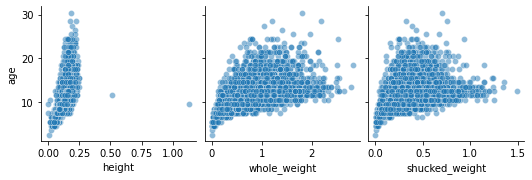

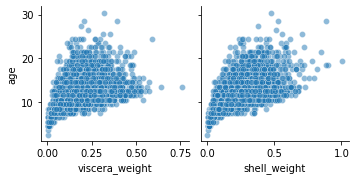

In [179]:
sns.pairplot(data=abalone, y_vars=['age'], x_vars=['sex', 'length', 'diameter'], plot_kws={'alpha':0.5})         
sns.pairplot(data=abalone, y_vars=['age'], x_vars=['height', 'whole_weight', 'shucked_weight'], plot_kws={'alpha':0.5})         
sns.pairplot(data=abalone, y_vars=['age'], x_vars=['viscera_weight', 'shell_weight'], plot_kws={'alpha':0.5})

plt.show()

## Data preprocessing

First of all, let's check if there are any null values.

In [180]:
abalone.isnull().sum() 

sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
age               0
dtype: int64

Hooray! There are no null values. Next, let's change the 'sex' column to just contain numerical values, and then normalise the data so that it all has a mean of 0 and standard deviation of 1.

In [181]:
#map sex values to numbers
features.sex = features.sex.map({'M': 0, 'F': 1, 'I': 2})

#standardise the inputs
scaler = StandardScaler()
features_temp = scaler.fit_transform(features.iloc[:, 1:])

## Statistical Analysis

Let's do a correlation test between age and each variable, to see how much of an effect each variable has on age. For this, the null hypothesis of each test would be that there is no correlation between the variable and age, and the alternative hypothesis would be that there _is_ a correlation.

In [182]:
results = []
for column in features.columns[1:]:
    corr, pval = pearsonr(ages, features[column])
    if pval < 0.05:
        results.append([str(column), corr, pval, 'Yes'])
    else:
        results.append([str(column), corr, pval, 'No'])
headers = ['Feature', 'Correlation Coefficient', 'p-value', 'Reject Null?']
results = pd.DataFrame(results, columns=headers)
results

,Feature,Correlation Coefficient,p-value,Reject Null?
0,length,0.556720,0.000000e+00,Yes
1,diameter,0.574660,0.000000e+00,Yes
2,height,0.557467,0.000000e+00,Yes
3,whole_weight,0.540390,1.888678e-315,Yes
4,shucked_weight,0.420884,5.087464e-179,Yes
5,viscera_weight,0.503819,8.574726e-268,Yes
6,shell_weight,0.627574,0.000000e+00,Yes


As we can see, all of the features correlate with age somewhat, as the null hypothesis is rejected for each variable. So, it makes sense to include all of these features in the analysis. One note is that 'sex' is not included in the analysis, because one of the sexes is 'infant', which would lead to bias because 'infant' means that the abalone is younger. See the figure below. 

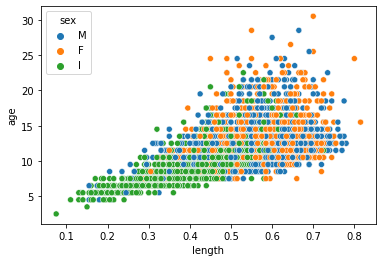

In [183]:
sns.scatterplot(abalone.length, abalone.age, hue=abalone.sex)
plt.show()

As we can see above, most of the infant abalones are clustered at the bottom, meaning that they are younger. This would then make for easier regression, to tell the age of an abalone by its sex. However, in order to know if it's an infant, you need to know its age, which is counter-productive. And also, the males and females seem to be very mixed (there is no clear pattern), so telling whether they are male or female would not help.

## Building the model

Let's now build the machine learning model, which uses the `LinearRegression` from Scikit-learn.

In [184]:
# split the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(features_temp, ages, train_size=0.8)

#declare the model
model = LinearRegression()

#fit the model with the training data
model.fit(x_train, y_train)

LinearRegression()

Now we can see how well the model performs.

In [185]:
score_train = model.score(x_train, y_train)
score_test = model.score(x_test, y_test)
print("The training score is " + str(score_train))
print("The testing score is " + str(score_test))

The training score is 0.5231653633027562
The testing score is 0.5449636567762296


Oddly, the model performs better on unseen data than the training data, which if anything is a good thing, because it means that there is a very low chance of overfitting. Let's now see the predictions of the model.

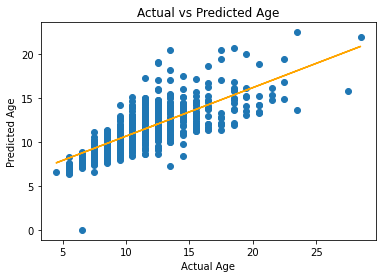

The gradient is 0.5526790600907235


In [190]:
y_predicted = model.predict(x_test)
plt.scatter(y_test, y_predicted)
m, c = np.polyfit(y_test, y_predicted, 1) #calculate line of best fit
plt.plot(y_test, m*y_test+c, color='orange')
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age")
plt.show()

print("The gradient is " + str(m))

The gradient is quite far away from 1, so the model is far from perfect. 

# Conclusion

This project used a machine learning regression analysis to predict the ages of abalones with different characteristics. The model maintained good accuracy on the test dataset, meaning that there was little overfitting. In a different study, different features of the abalone/animal could be taken, because they seem to be all correlated with each other - see the figure below.

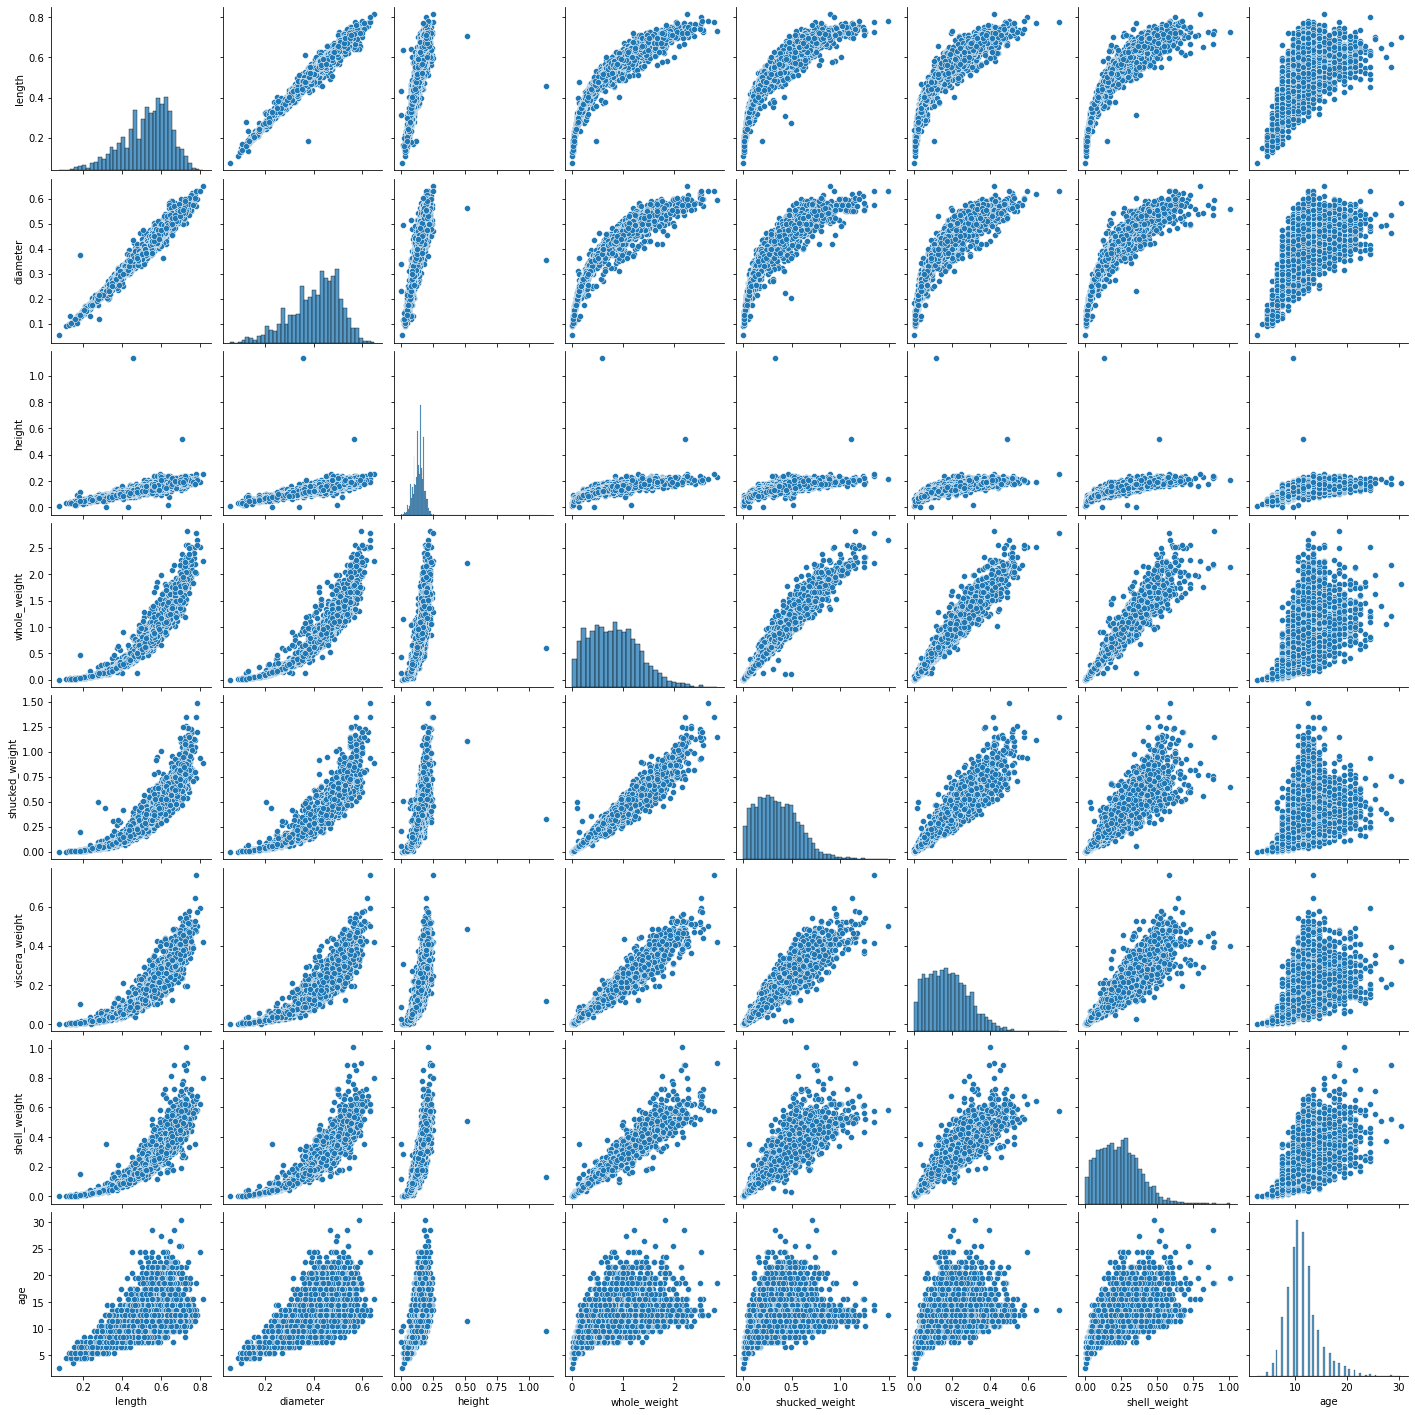

In [192]:
sns.pairplot(abalone)
plt.show()

In the figure above, we can see that many different features are correlated with each other, such as 'whole_weight' and 'shucked_weight'. Adding new features to this dataset that aren't correlated with the others would provide more information and would allow the regression model to pick 